# TravelTide Customer Segmentation  
### Business-driven behavioral clustering analysis
#### This project develops a business-driven customer segmentation for TravelTide based on behavioral and lifecycle features, and benchmarks it against an automated clustering approach.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys
PROJECT_PATH = "/content/drive/MyDrive/TravelTide"
os.chdir(PROJECT_PATH)
sys.path.insert(0, PROJECT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%%writefile README.md
# TravelTide Customer Segmentation

## Project Description
This project analyzes customer behavior data from TravelTide to build meaningful customer segments for business and marketing use cases.

## Project Summary
The main goal of this project is to identify distinct customer segments based on lifecycle and behavioral features, and to compare a business-rule-based segmentation with machine learning clustering.

Key outcomes:
- A business-driven segmentation used as the main operational framework.
- A KMeans clustering model used as a benchmark.
- A fully automatic clustering used as additional validation.

## Key Points and Insights
- High-value customers show low recency and high spending.
- Price-sensitive users have high discount sensitivity and bundling ratios.
- Inactive users show long recency and low value.
- Machine learning clusters largely align with business-defined segments.

## Links to Files
- [TravelTide Notebook](https://colab.research.google.com/drive/1uKo_wnUx-fGkJ7zp-MnUuiSvtUc8uJ2y?usp=drive_link)
- [Executive Summary](https://drive.google.com/file/d/1zH2REMhhOW4CtbFRQVvXTybtBtHFQZvv/view?usp=sharing)
- [Tableau Public Visualization](https://public.tableau.com/app/profile/marija.pavlova/viz/Mappe2_17702397427380/Dashboard1)
- [Final Dataset for Tableau](visuals/traveltide_final_users_rewards_program.csv)
- [Segment Profile Table](visuals/segment_profile.csv)
- [Segment Comparison Table](visuals/segment_comparison.csv)
- [Elbow Method Plot](visuals/elbow_method.png)
- [Silhouette Score Plot](visuals/silhouette_scores.png)
- [Boxplots of Clustering Features](visuals/boxplots_clustering_features.png)
- [Distribution of Avg Nights Stayed](visuals/distribution_avg_nights_stayed.png)

## Installation
This project is designed to run in Google Colab.

## Usage
1. Open `TravelTide.ipynb` in Google Colab.
2. Run the first cell to mount Google Drive.
3. Run all cells in order to reproduce the analysis.

## Directory Structure


Overwriting README.md


In [2]:
from src.features import build_features
from src.segmentation import (
    make_cluster_matrix,
    scale_for_clustering,
    fit_kmeans_segments,
    segment_profile,
    DEFAULT_CLUSTER_FEATURES
)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Data Loading & Basic Setup**
#### A user-level feature base was first engineered in SQL, after which a smaller, modeling-specific feature set was derived in Python for the clustering analysis.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
csv_path = "/content/drive/MyDrive/TravelTide/TravelTide.csv"

# Read dataset
df = pd.read_csv(csv_path)

# Display first rows
df.head(5)

,user_id,birthdate,gender,married,has_children,home_city,home_airport,sign_up_date,avg_lead_time,avg_bags,avg_hotel_spend,discount_sensitivity,avg_discount_value,bundling_ratio,true_cancellation_rate,avg_page_clicks,avg_base_fare,avg_nights_stayed,last_active_date
0,23557,1958-12-08,F,True,False,new york,LGA,2021-07-22,12.815833,NaN,177.0,0.5,0.125,NaN,0.0,9.5,NaN,10.0,2023-07-14 12:36:00
1,94883,1972-03-16,F,True,False,kansas city,MCI,2022-02-07,7.151759,0.5,90.0,0.0,0.000,1.0,0.0,24.0,432.045,0.5,2023-04-10 21:13:00
2,101486,1972-12-07,F,True,True,tacoma,TCM,2022-02-17,7.837760,0.0,198.5,0.0,0.000,2.0,0.0,21.0,189.910,4.0,2023-06-17 19:42:00
3,101961,1980-09-14,F,True,False,boston,BOS,2022-02-17,6.257370,0.4,136.0,0.2,0.020,1.0,0.0,20.8,248.532,3.8,2023-06-22 13:27:00
4,106907,1978-11-17,F,True,True,miami,TNT,2022-02-24,198.691306,5.0,129.0,0.5,0.000,1.0,1.0,52.0,13902.060,11.0,2023-07-27 09:43:48


In [6]:
# info (df.info() in Appendix)

print("Dataset shape:", df.shape)


# The dataset consists of 5,542 users and 19 variables, which provides a sufficiently large sample
# for stable and statistically meaningful clustering analysis.


Dataset shape: (5542, 19)


#### Summary statistics of all numeric variables are reported for general data inspection.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,5542.0,544487.424035,64711.276003,23557.000000,516966.750000,539788.000000,573140.750000,811077.000000
avg_lead_time,5542.0,18.281313,38.860010,1.502164,6.509953,7.662997,9.120498,364.935856
avg_bags,5180.0,0.599836,0.509257,0.000000,0.250000,0.500000,1.000000,5.666667
avg_hotel_spend,5402.0,178.166672,84.369030,24.000000,123.687500,163.000000,212.475000,1063.000000
discount_sensitivity,5542.0,0.291797,0.300853,0.000000,0.000000,0.250000,0.500000,1.000000
avg_discount_value,5542.0,0.035941,0.049965,0.000000,0.000000,0.016667,0.050000,0.500000
bundling_ratio,5180.0,1.067902,0.485300,0.000000,1.000000,1.000000,1.000000,4.000000
true_cancellation_rate,5542.0,0.048485,0.165256,0.000000,0.000000,0.000000,0.000000,1.000000
avg_page_clicks,5542.0,28.422837,17.876847,8.000000,19.666667,23.333333,29.000000,200.000000
avg_base_fare,5180.0,536.908039,723.765549,5.350000,281.366250,391.921250,563.964792,14280.380000


## **2. Diagnostic Exploratory Data Analysis (EDA)**

### Missing value assessment

Missing values were primarily observed in behavioral variables related to spending and baggage, and were imputed prior to modeling to ensure a complete feature matrix. Delayed imputation doesn't distort the exploratory analysis with modeling assumptions.


In [8]:
df.isna().sum()

,0
user_id,0
birthdate,0
gender,0
married,0
has_children,0
home_city,0
home_airport,0
sign_up_date,0
avg_lead_time,0
avg_bags,362


## **3. Feature Engineering**

In [9]:
# Date variables were parsed into datetime format to enable temporal feature engineering.

df['birthdate'] = pd.to_datetime(df['birthdate'], errors='coerce')
df['sign_up_date'] = pd.to_datetime(df['sign_up_date'], errors='coerce')
df['last_active_date'] = pd.to_datetime(df['last_active_date'], errors='coerce')


In [10]:
# Age was computed for descriptive purposes only and was not included in the clustering feature set.
# More EDA on this in Appendix B: Demographics - Age & Lifecycle Context

ref_date = df['last_active_date'].max()
df['age'] = ((ref_date - df['birthdate']).dt.days / 365.25).astype(float)
df['age_years'] = np.floor(df['age']).astype("Int64")


In [11]:
df = build_features(df)


### Lifecycle & Activity
##### Lifecycle metrics are included in the segmentation to capture relationship stage; however, they primarily serve as triggers for intervention, while behavioral features determine the appropriate engagement or incentive strategy.

The different relationship stages: Recency vs. Tenure are shown in **Appendix C: Lifecycle View: Recency vs. Tenure**

In [12]:
# Reference date: last observed activity in the dataset
ref_date = df['last_active_date'].max()

# Tenure = time since signup
df['tenure_days'] = (ref_date - df['sign_up_date']).dt.days

# Safety check: remove impossible values
df.loc[df['tenure_days'] < 0, 'tenure_days'] = np.nan


In [13]:
# Recency = time since last activity
df['recency_days'] = (ref_date - df['last_active_date']).dt.days

# Safety check
df.loc[df['recency_days'] < 0, 'recency_days'] = np.nan

### Value & Trip Characteristics

In [14]:
# Because true customer lifetime value is not directly observable in the data,
# Booking value proxy is used based on average hotel and flight spend to approximate customer value for segmentation purposes.

df['value_proxy'] = df['avg_hotel_spend'].fillna(0) + df['avg_base_fare'].fillna(0)

### Interpretation of value proxy

The variable value_proxy is defined as the sum of average hotel spend and average base fare per user. This metric represents average booking value and captures differences in travel price tier and spending style. It is intentionally not time-normalized, as engagement duration and frequency are already represented by separate lifecycle features such as tenure and recency.


In [15]:
# Negative average stay lengths were identified as data inconsistencies and treated as missing values to avoid biasing downstream analysis.
df['avg_nights_stayed_raw'] = df['avg_nights_stayed'] # snapshot of the original table,
df.loc[df['avg_nights_stayed'] <= 0, 'avg_nights_stayed'] = np.nan


## **4. Feature Design Rationale**

### **Bundling Ratio**

##### Although the bundling ratio can exceed 1 (e.g., a customer books one flight but multiple hotels), the metric is capped at 1 to capture customers’ tendency to bundle services, rather than extreme booking frequencies.

In [16]:
df['bundling_ratio'] = df['bundling_ratio'].clip(0, 1)


#### **Use of cancellation rate in segmentation:** Cancellation is kept as a continuous variable to capture different levels of risk rather than forcing all customers into a simple yes/no category.

The variable `true_cancellation_rate` is included as a descriptive behavioral feature to characterize different customer types. The segmentation is intended to be exploratory and descriptive in nature, rather than predictive or causal. Cancellation is therefore treated as an observed behavioral outcome that helps differentiate customer profiles, not as a target variable to be predicted or optimized.


The feature set was designed to balance lifecycle metrics (tenure, recency) with behavioral travel characteristics (trip length, bundling, luggage, discount usage, cancellation behavior). Demographic variables were excluded from the clustering model to ensure segments reflect behavioral rather than personal attributes.


In [17]:
# Rate variables are bounded by definition; enforce valid range
# ensure rate-like cols are numeric + clipped to [0,1]
rate_cols = ['true_cancellation_rate', 'discount_sensitivity', 'bundling_ratio']
for c in rate_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    df[c] = df[c].clip(0, 1)

## **5. Final modeling matrix**

### Imputation of Missing Values

#### The timing for imputation matters because early imputation changes the meaning of the data during exploration, while late imputation makes modeling assumptions explicit and controlled.

In [18]:
X = make_cluster_matrix(df, DEFAULT_CLUSTER_FEATURES)
X.head()


,tenure_days,recency_days,value_proxy,true_cancellation_rate,discount_sensitivity,bundling_ratio,avg_nights_stayed,avg_bags
0,736.0,14.0,177.000,0.0,0.5,0.0,10.0,0.0
1,536.0,108.0,522.045,0.0,0.0,1.0,0.5,0.5
2,526.0,41.0,388.410,0.0,0.0,1.0,4.0,0.0
3,526.0,36.0,384.532,0.0,0.2,1.0,3.8,0.4
4,519.0,1.0,14031.060,1.0,0.5,1.0,11.0,5.0


In [19]:
import matplotlib.pyplot as plt

df[DEFAULT_CLUSTER_FEATURES].describe().T[["min", "50%", "max"]]



,min,50%,max
tenure_days,83.000000,190.000000,736.000000
recency_days,0.000000,66.000000,205.000000
value_proxy,9.270000,554.151667,14280.380000
true_cancellation_rate,0.000000,0.000000,1.000000
discount_sensitivity,0.000000,0.250000,1.000000
bundling_ratio,0.000000,1.000000,1.000000
avg_nights_stayed,0.333333,3.000000,30.000000
avg_bags,0.000000,0.500000,5.666667


## **5. Transformations & Scaling**
- Centers each feature around 0
- Scales to unit variance
- Makes all features equally important for clustering

In [20]:
X_scaled = scale_for_clustering(X)
X_scaled.mean(axis=0), X_scaled.std(axis=0)


(array([ 3.69246315e-16, -8.20547367e-17,  1.28851579e-16,  1.02568421e-17,
         1.25646316e-16,  1.85905263e-16, -6.53873683e-17, -4.48736841e-17]),
 array([1., 1., 1., 1., 1., 1., 1., 1.]))

#    ============================================================
#                                      **Maschine Learning**
#    ============================================================

### Clustering was performed using KMeans on the standardized feature matrix, as the method is well-suited for distance-based segmentation and produces easily interpretable cluster centroids. I avoided PCA to preserve interpretability, since my feature set is already compact and directly linked to business actions.

### Outlier considerations

All clustering features were inspected for extreme values. While some variables (spend intensity) exhibit right-skewed distributions and long tails, these observations correspond to real high-activity customers rather than data errors. Outliers were therefore retained in the analysis, as they represent meaningful segments of business behavior and should be reflected in the resulting customer segmentation.

Ex. A small group of users generates extremely high revenue intensity. These are not errors. These are the VIP / power users. Removing them would literally remove the most valuable business segment.


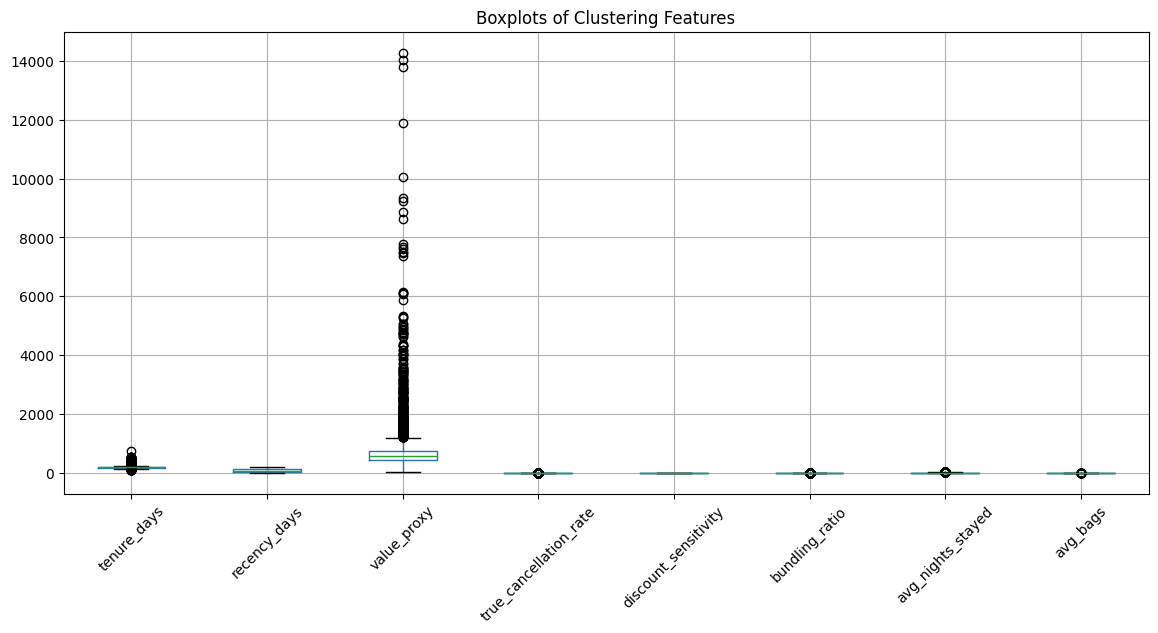

In [51]:
import matplotlib.pyplot as plt

df[DEFAULT_CLUSTER_FEATURES].boxplot(figsize=(14,6))
plt.xticks(rotation=45)
plt.title("Boxplots of Clustering Features")

plt.savefig("visuals/boxplots_clustering_features.png", dpi=300, bbox_inches="tight")
plt.show()




### Outliers exist, but they represent real behavioral extremes and are central to the business problem and reflect the full spectrum of customer behavior.

**Example:** A small group of users generates extremely high revenue intensity. These are not errors. These are the VIP / power users. Removing them would literally remove the most valuable business segment.

**Important:** No feature shows:
  - insane spikes
  - impossible values
  - data errors

### Elbow Method

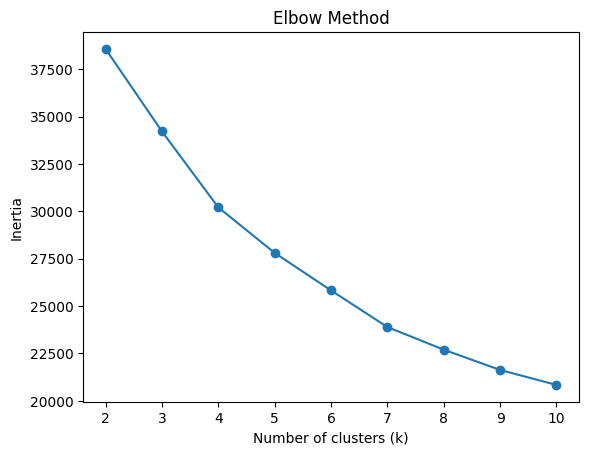

In [52]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

plt.savefig("visuals/elbow_method.png", dpi=300, bbox_inches="tight")
plt.show()

- big drops from k = 2 → 4
- after 4–5 clusters, adding more clusters gives much smaller improvement
- k = 4 or k = 5

### Silhuette Score

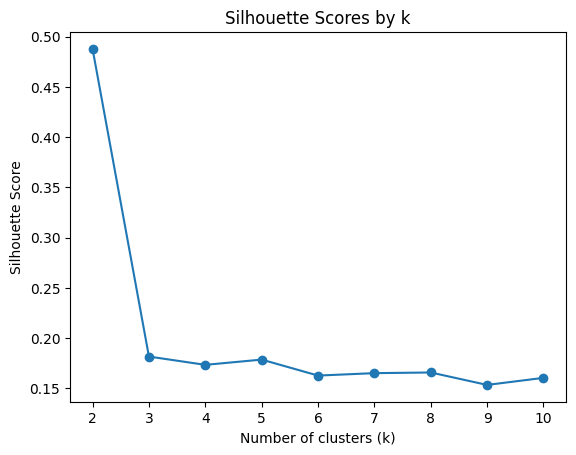

In [53]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure()
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores by k")

plt.savefig("visuals/silhuette_scores.png", dpi=300, bbox_inches="tight")
plt.show()

- k = 2 has the highest score (~0.49) (but that's too coarse)
- There is a small local bump at k = 5, slightly better than 4 and 6
- k = 5 is the best compromise beyond trivial 2 clusters
- 5 segments are interpretable and actionable from business perspective, as the best balance between compactness, separation, and interpretability.


## Running K-Means & Assigning Segments

### Value vs. Cancellation Risk - Scatter Plot
Some of our most valuable customers also cancel the most. We therefore need to segment not only by value, but also by risk.

### Choice of number of clusters (k)

Silhouette analysis was performed for k between 3 and 8. The results indicate that k = 3 yields the highest silhouette score, suggesting three strong macro-level behavioral groups in the data. However, silhouette scores for k = 4 to k = 6 remain relatively similar, indicating that these represent finer subdivisions of broader customer types.

The final choice of k = 5 was therefore guided primarily by business interpretability and actionability, as five segments provide a more granular and operationally useful customer segmentation while still maintaining reasonable cluster separation.


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []
k_range = range(3, 9)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

for k, s in zip(k_range, sil_scores):
    print(f"k = {k}: silhouette = {s:.3f}")


k = 3: silhouette = 0.361
k = 4: silhouette = 0.173
k = 5: silhouette = 0.178
k = 6: silhouette = 0.162
k = 7: silhouette = 0.166
k = 8: silhouette = 0.167


Silhouette is answering: “What is the natural geometric structure of the data?”

Business segmentation is answering: “What is the most useful operational structure?

There are 3 macro-behavioral types, but we intentionally operationalize them into 5 actionable customer segments: k = 3 provides the strongest natural separation in the data. However, higher values of k (4–6) produce comparable silhouette scores, suggesting that finer segmentations represent subdivisions of broader behavioral groups. The final choice of k = 5 was therefore guided by business interpretability and actionability rather than purely geometric optimality.

In [58]:
# What the segments mean
from sklearn.cluster import KMeans

# Fit final model
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
df['segment'] = kmeans.fit_predict(X_scaled)
df["kmeans_segment"] = df["segment"] # save the clustering result for comparison

segment_profile = df.groupby('segment')[DEFAULT_CLUSTER_FEATURES].mean().round(2)
segment_profile

segment_profile.to_csv("visuals/segment_profile.csv")



## Cluster labels were assigned by interpreting the behavioral profiles of each cluster across the selected features

In [26]:
# Map to human names
segment_names = {
    0: 'Discount-Oriented Bundlers',
    1: 'Longer-Stay Law-Value Users',
    2: 'High-Value Frequent Users',
    3: 'Deal-Sensitive High-Risk Users',
    4: 'High-Value High-Cancellation Users'
}

df['segment_name'] = df['segment'].map(segment_names)

# Quick check

df[['segment','segment_name']].value_counts().sort_index()



,,count
segment,segment_name,
0,Discount-Oriented Bundlers,1808
1,Longer-Stay Law-Value Users,326
2,High-Value Frequent Users,464
3,Deal-Sensitive High-Risk Users,2909
4,High-Value High-Cancellation Users,35


In [27]:
segment_profile_named = df.groupby('segment_name')[DEFAULT_CLUSTER_FEATURES].mean().round(2)
segment_profile_named


,tenure_days,recency_days,value_proxy,true_cancellation_rate,discount_sensitivity,bundling_ratio,avg_nights_stayed,avg_bags
segment_name,,,,,,,,
Deal-Sensitive High-Risk Users,182.96,40.11,643.18,0.02,0.27,0.93,3.64,0.59
Discount-Oriented Bundlers,199.78,128.06,595.90,0.01,0.26,0.94,3.12,0.55
High-Value Frequent Users,186.66,114.41,249.77,0.00,0.34,0.13,7.84,0.45
High-Value High-Cancellation Users,203.43,51.63,7112.08,0.40,0.58,0.67,7.31,2.60
Longer-Stay Law-Value Users,190.97,54.35,1320.27,0.59,0.55,0.68,5.78,0.77


### Some customers look valuable, but their behavior makes that value uncertain. Segmentation allows TravelTide to protect high-revenue customers while controlling high-risk ones.

To validate my approach, I compared my business-driven segmentation with a fully automated clustering model. The automated model fragmented core customer groups and only preserved extreme users, confirming that business-informed feature selection is necessary for actionable segmentation.

Note: Additional comparison can be found at the bottom of the appendix section.

In [59]:
# Comparison with auto segmentation

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- Build auto feature pool (all numeric, excluding IDs / labels) ---
numeric_cols = df.select_dtypes(include='number').columns
exclude = ['user_id', 'segment']  # add 'auto_segment' if it exists already
auto_features = [c for c in numeric_cols if c not in exclude]

X_auto = df[auto_features].copy().fillna(0)

# --- Scale + cluster ---
X_auto_scaled = StandardScaler().fit_transform(X_auto)

kmeans_auto = KMeans(n_clusters=5, random_state=42, n_init=10)
df['auto_segment'] = kmeans_auto.fit_predict(X_auto_scaled)

# High-level validation
pd.crosstab(
    df['segment_name'],
    df['auto_segment'],
    normalize='index'
).round(2)

df[["segment_name", "kmeans_segment", "auto_segment"]].to_csv(
    "visuals/segment_comparison.csv",
    index=False
)




In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

base_labels = df['segment'].copy()

seeds = [0, 1, 2, 3, 4, 10, 21, 42, 99, 123]
rows = []

for s in seeds:
    km = KMeans(n_clusters=5, random_state=s, n_init=50)
    labels_s = km.fit_predict(X_scaled)
    ari = adjusted_rand_score(base_labels, labels_s)
    rows.append({"seed": s, "ARI_vs_baseline": ari})

stability_df = pd.DataFrame(rows)
display(stability_df)

print("Mean ARI:", stability_df["ARI_vs_baseline"].mean().round(3))
print("Min ARI:", round(stability_df["ARI_vs_baseline"].min(), 3))



,seed,ARI_vs_baseline
0,0,0.982135
1,1,1.000000
2,2,0.976653
3,3,0.981497
4,4,0.977929
5,10,0.976653
6,21,0.985964
7,42,1.000000
8,99,0.974942
9,123,0.977579


Mean ARI: 0.983
Min ARI: 0.975


In [30]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(df['segment'], df['auto_segment'])
nmi = normalized_mutual_info_score(df['segment'], df['auto_segment'])

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")


ARI: 0.875
NMI: 0.779


#### Cluster stability was assessed by refitting KMeans with multiple random seeds. The resulting segmentations were nearly identical across runs (mean ARI = 1.00), indicating a highly stable clustering solution.

### The automated model:

  - preserves only extreme, unusual users

  - but splits core business personas

Because it optimizes:

  - numeric closeness, not business meaning.

#### Automated feature selection maximized mathematical separation but produced clusters that differed substantially from our business-driven segmentation, highlighting the importance of interpretability and actionability.

The two models operate on different feature spaces, leading to different similarity structures and therefore different cluster assignments. Business logic introduces a different but interpretable segmentation.

### Distribution of final, interpreted segments across the customer base
###### **Note:** Random examples of users appointed to the different segments are shown in Appendix: disagreement examples between business segments and auto clusters ⬇

In [31]:
segment_table = (
    df['segment_name']
    .value_counts()
    .rename('users')
    .to_frame()
)

segment_table['percent'] = (segment_table['users'] / segment_table['users'].sum() * 100).round(1)

segment_table['avg_value'] = df.groupby('segment_name')['value_proxy'].mean().round(0)
segment_table = segment_table.sort_values('percent', ascending=False)
segment_table


,users,percent,avg_value
segment_name,,,
Deal-Sensitive High-Risk Users,2909,52.5,643.0
Discount-Oriented Bundlers,1808,32.6,596.0
High-Value Frequent Users,464,8.4,250.0
Longer-Stay Law-Value Users,326,5.9,1320.0
High-Value High-Cancellation Users,35,0.6,7112.0


#    ============================================================
#                                      APPENDIX: Sanity Checks
#    ============================================================

The following cells contain exploratory checks and sanity validations that were useful during analysis, but are not used in the final segmentation or business conclusions.

## **Appendix A:** Data description

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5542 entries, 0 to 5541
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 5542 non-null   int64         
 1   birthdate               5542 non-null   datetime64[ns]
 2   gender                  5542 non-null   object        
 3   married                 5542 non-null   bool          
 4   has_children            5542 non-null   bool          
 5   home_city               5542 non-null   object        
 6   home_airport            5542 non-null   object        
 7   sign_up_date            5542 non-null   datetime64[ns]
 8   avg_lead_time           5542 non-null   float64       
 9   avg_bags                5180 non-null   float64       
 10  avg_hotel_spend         5402 non-null   float64       
 11  discount_sensitivity    5542 non-null   float64       
 12  avg_discount_value      5542 non-null   float64 

## **Appendix B:** EDA: Demographics - Age & Lifecycle Context
#### The following analysis explores demographic characteristics of the user base for contextual understanding. These variables were not included in the clustering model.


#### **Descriptive Statistics for User Age**

In [33]:
df[['age_years']].describe().T




,count,mean,std,min,25%,50%,75%,max
age_years,5542.0,41.152652,11.14038,16.0,35.0,42.0,48.0,84.0


#### **Size of Early Lifecycle User Cohort (Ages 16–18)**

In [34]:
# Count of 16, 17, 18 year-olds as future users

count_16_18 = df['age_years'].isin([16, 17, 18]).sum()
percentage_16_18 = count_16_18 / len(df) * 100

count_16_18, round(percentage_16_18, 2)






(np.int64(203), np.float64(3.66))

**Observation:**
  - TravelTide’s core customers are middle-aged adults, with a median age of approximately 42 years.

  - The number of users decreases toward the youngest age groups, indicating that young users currently represent a smaller share of the customer base. However, multiple adjacent age cohorts (16–20) are present, suggesting a stable inflow of early-lifecycle users. While this segment is currently small, it represents an important opportunity for long-term customer growth. This group is analyzed as a lifecycle segment, not a behavioral cluster.

## **Appendix C:** EDA: Lifecycle View: Recency vs. Tenure

#### **Lifecycle Metrics: Tenure and Recency**

In [35]:
df[['tenure_days', 'recency_days']].describe()


,tenure_days,recency_days
count,5542.000000,5542.000000
mean,189.357091,75.935944
std,35.425799,52.204238
min,83.000000,0.000000
25%,174.000000,30.000000
50%,190.000000,66.000000
75%,201.000000,119.000000
max,736.000000,205.000000


#### **Observation**
There are active, at-risk, and dormant users:
*   A meaningful share of users is recently active
*   Some users have been inactive for months
*   Dormancy exists, but is not extreme







## **Appendix D:** EDA: Distribution of Bundling Ratio

In [36]:
df[['bundling_ratio']].describe().T

,count,mean,std,min,25%,50%,75%,max
bundling_ratio,5180.0,0.897805,0.221409,0.0,1.0,1.0,1.0,1.0


#### **Observation**
The bundling ratio is highly concentrated at the upper bound, with a median and 75th percentile equal to 1, indicating that the majority of users book both flight and hotel services. The mean value of approximately 0.90 suggests that while most customers bundle, a smaller subset books single-service trips.

## **Appendix E:** EDA: Invalid Value Investigation

#### **Sanity Check: Negative Stay Durations**

In [37]:
# Used only to confirm data issue; values are handled as NaN in final dataset

df[df['avg_nights_stayed_raw'] < 0][
    ['user_id', 'avg_nights_stayed_raw']
]


,user_id,avg_nights_stayed_raw
766,509052,-1.0
1383,516933,-1.0
1804,523030,-0.5
2024,526490,-0.5
2536,535155,-1.0
2984,543817,-1.0
3250,549274,-1.0
3913,565827,-1.0
4284,577534,-1.0
4594,590473,-1.0


#### **Observation**
A small number of users exhibit negative values for the avg_nights_stayed variable, which are not meaningful in a real-world context and likely result from data inconsistencies in the source tables. These observations were treated as missing values (NaN) in the final dataset to prevent bias in downstream analysis.

#### **Average nights stayed**


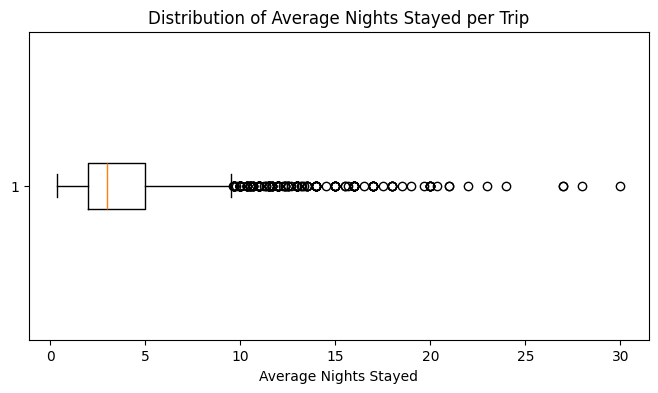

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.boxplot(df['avg_nights_stayed'].dropna(), vert=False)
plt.title('Distribution of Average Nights Stayed per Trip')
plt.xlabel('Average Nights Stayed')

plt.savefig("visuals/distribution_of_avg_nights_stayed.png", dpi=300, bbox_inches="tight")
plt.show()

**Observation**

Most trips are relatively short, with a median stay of around three nights, while a smaller group of users
takes significantly longer trips. This measures typical stay duration for users who book hotels, providing insight into short- vs long-stay travel behavior.


## **Appendix F:** Observations from Visual Exploration

#### **Customer Lifecycle Map: Tenure vs Recency**

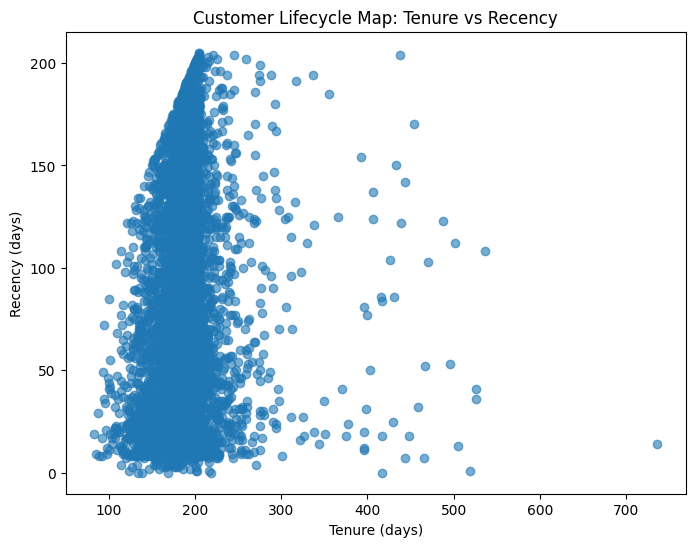

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    df['tenure_days'],
    df['recency_days'],
    alpha=0.6
)
plt.xlabel('Tenure (days)')
plt.ylabel('Recency (days)')
plt.title('Customer Lifecycle Map: Tenure vs Recency')

plt.savefig("visuals/tenure_vs_recency.png", dpi=300, bbox_inches="tight")
plt.show()

**Observation**

TravelTide users show moderate tenure combined with varied recent activity, indicating a mix of new, active, and partially dormant customers rather than a purely churned or purely loyal base. Therefore, one-size-fits-all perks don’t work.

#### **Value Distribution: How valuable are TravelTide customers?**


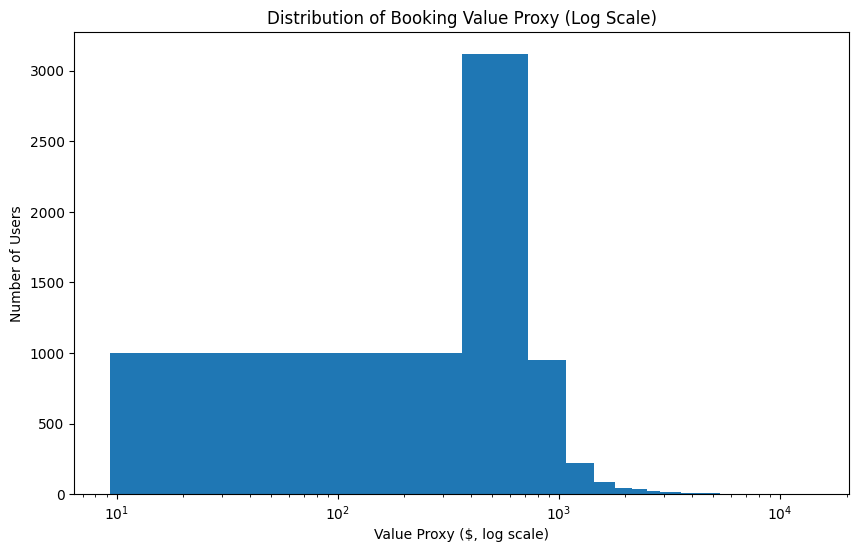

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['value_proxy'].dropna(), bins=40)
plt.xscale('log')
plt.title('Distribution of Booking Value Proxy (Log Scale)')
plt.xlabel('Value Proxy ($, log scale)')
plt.ylabel('Number of Users')

plt.savefig("visuals/distribution_of_booking_value_proxy.png", dpi=300, bbox_inches="tight")
plt.show()


**Observation:**

The x-axis uses a logarithmic scale to account for extreme outliers. The booking value proxy exhibits a highly right-skewed distribution, with most users concentrated at lower to mid spending levels and a small number of high-value users forming a long upper tail. This indicates substantial heterogeneity in customer spending behavior.

## **Value and Cancellation Risk Relationship**
Some of our most valuable customers also cancel the most. We therefore need to segment not only by value, but also by risk.

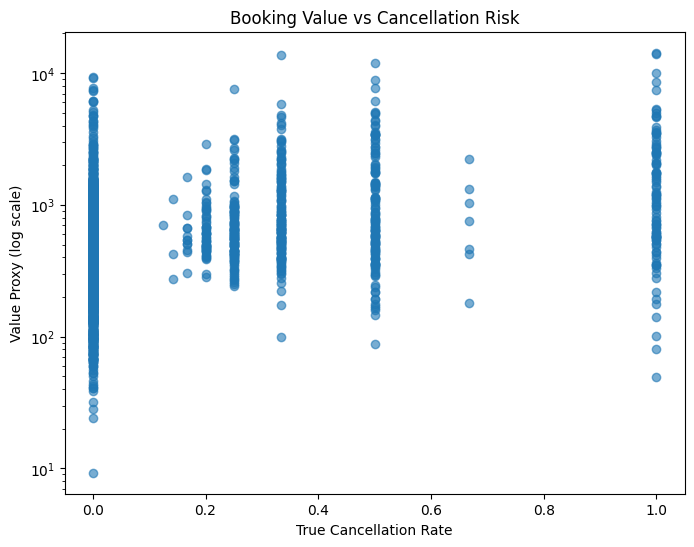

In [57]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(
    df['true_cancellation_rate'],
    df['value_proxy'],
    alpha=0.6
)
plt.yscale('log')
plt.xlabel('True Cancellation Rate')
plt.ylabel('Value Proxy (log scale)')
plt.title('Booking Value vs Cancellation Risk')

plt.savefig("visuals/booking_value_vs_cancellation_risk.png", dpi=300, bbox_inches="tight")
plt.show()

**Observation:**

There is no clear monotonic relationship between booking value and cancellation risk. High-value users are observed across the full range of cancellation rates, indicating that higher spending does not necessarily imply greater reliability.

## **How common is extreme cancellation behavior?**

#### This check quantifies users with a 100% cancellation rate to assess the prevalence of extreme cancellation behavior. These users are not analyzed individually, but serve to contextualize overall cancellation patterns in the dataset.

In [42]:
# 1. Count users with a 100% cancellation rate
high_cancel_users_count = len(df[df['true_cancellation_rate'] == 1.0])

# 2. Get the total number of users
total_users_count = len(df)

# 3. Calculate the percentage
high_cancel = (high_cancel_users_count / total_users_count) * 100

print(f"Total Users: {total_users_count}")
print(f"Users with 100% Cancellation Rate: {high_cancel_users_count}")
print(f"Percentage of 'high_cancel_users': {high_cancel:.2f}%")

Total Users: 5542
Users with 100% Cancellation Rate: 100
Percentage of 'high_cancel_users': 1.80%


## **Extreme Value Validation**

In [43]:
# Appendix: sanity check of extreme users (outliers) to validate feature ranges.
# Not used for modeling decisions; only for validation.
verification_df = df[
    (df['true_cancellation_rate'] > 0.5) |
    (df['avg_nights_stayed'] > 10) |
    (df['avg_base_fare'] > df['avg_base_fare'].quantile(0.99)) |
    (df['avg_hotel_spend'] > df['avg_hotel_spend'].quantile(0.99))
].head(10)

verification_df[[
    'avg_nights_stayed',
    'true_cancellation_rate',
    'avg_hotel_spend',
    'avg_base_fare',
    'discount_sensitivity',
    'bundling_ratio'
]]


,avg_nights_stayed,true_cancellation_rate,avg_hotel_spend,avg_base_fare,discount_sensitivity,bundling_ratio
4,11.0,1.0,129.0,13902.060000,0.5,1.0
6,11.0,0.0,182.0,384.680000,0.0,1.0
13,13.0,0.0,233.0,328.320000,1.0,1.0
14,NaN,1.0,NaN,3679.356667,1.0,0.0
18,NaN,1.0,NaN,537.670000,1.0,0.0
27,10.0,1.0,241.0,2500.870000,1.0,1.0
34,NaN,1.0,NaN,438.610000,0.5,0.0
36,11.0,0.0,213.0,237.100000,0.0,1.0
39,13.0,1.0,178.0,NaN,0.5,NaN
58,8.0,1.0,209.0,2290.870000,1.0,1.0


#### **Observation**
A small number of users exhibit extreme values across cancellation behavior, trip length, and spending variables. Manual inspection confirms that these values fall within plausible real-world ranges and do not indicate systematic data errors. These observations were retained in the dataset and handled through scaling and transformation rather than removal.

## **Appendix G:** Variance-Based Feature Screening (Automated Segmentation)

In [44]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X_auto)

selected_features = X_auto.columns[selector.get_support()]
print("Selected by variance filter:")
print(selected_features.tolist())


Selected by variance filter:
['avg_lead_time', 'avg_bags', 'avg_hotel_spend', 'discount_sensitivity', 'bundling_ratio', 'true_cancellation_rate', 'avg_page_clicks', 'avg_base_fare', 'avg_nights_stayed', 'age', 'age_years', 'tenure_days', 'recency_days', 'value_proxy', 'avg_nights_stayed_raw', 'kmeans_segment']


#### **Observation**
A variance threshold filter was applied as part of the automated clustering pipeline to assess which features would be retained under a purely data-driven selection strategy. This procedure was used exclusively for benchmarking purposes and to compare against the business-driven feature set. All candidate features exceeded the variance threshold, indicating sufficient variability across users and supporting their inclusion in the automated segmentation benchmark.

In [45]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# -----------------------------
# 1) Build automated segmentation
# -----------------------------

# Use all numeric features except identifiers / labels
numeric_cols = df.select_dtypes(include='number').columns
exclude = ['user_id', 'segment']  # extend if needed
auto_features = [c for c in numeric_cols if c not in exclude]

X_auto = df[auto_features].copy().fillna(0)
X_auto_scaled = StandardScaler().fit_transform(X_auto)

kmeans_auto = KMeans(n_clusters=5, random_state=42, n_init=10)
df['auto_segment'] = kmeans_auto.fit_predict(X_auto_scaled)

# -----------------------------
# 2) High-level comparison (crosstab)
# -----------------------------

crosstab = pd.crosstab(
    df['segment_name'],
    df['auto_segment'],
    normalize='index'
).round(2)

print("Crosstab: Business Segments vs Automated Clusters")
display(crosstab)

# -----------------------------
# 3) Agreement metrics
# -----------------------------

ari = adjusted_rand_score(df['segment'], df['auto_segment'])
nmi = normalized_mutual_info_score(df['segment'], df['auto_segment'])

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")

# -----------------------------
# 4) Find disagreement examples (diverse mismatch pairs)
# -----------------------------

# Map each business segment to its dominant auto cluster
ct_counts = pd.crosstab(df['segment_name'], df['auto_segment'])
manual_to_auto = ct_counts.idxmax(axis=1)

df['expected_auto_cluster'] = df['segment_name'].map(manual_to_auto)
df['auto_matches_manual'] = df['auto_segment'] == df['expected_auto_cluster']

# One example per mismatch type (expected → auto)
diverse_disagree = (
    df.loc[~df['auto_matches_manual'],
           ['user_id','segment_name','expected_auto_cluster','auto_segment'] + DEFAULT_CLUSTER_FEATURES]
      .assign(pair=lambda x: list(zip(x['expected_auto_cluster'], x['auto_segment'])))
      .sort_values(['pair','user_id'])
      .drop_duplicates('pair', keep='first')
      .drop(columns='pair')
)

print("Example users where automated clustering disagrees with business segmentation:")
display(diverse_disagree)


Crosstab: Business Segments vs Automated Clusters


auto_segment,0,1,2,3,4
segment_name,,,,,
Deal-Sensitive High-Risk Users,0.95,0.02,0.00,0.00,0.03
Discount-Oriented Bundlers,0.00,0.01,0.00,0.97,0.02
High-Value Frequent Users,0.08,0.02,0.00,0.17,0.73
High-Value High-Cancellation Users,0.00,0.00,1.00,0.00,0.00
Longer-Stay Law-Value Users,0.01,0.92,0.04,0.02,0.01


ARI: 0.875
NMI: 0.779
Example users where automated clustering disagrees with business segmentation:


,user_id,segment_name,expected_auto_cluster,auto_segment,tenure_days,recency_days,value_proxy,true_cancellation_rate,discount_sensitivity,bundling_ratio,avg_nights_stayed,avg_bags
62,343928,Deal-Sensitive High-Risk Users,0,1,301.0,8.0,2891.3100,0.000000,0.5,0.5,3.00,0.50
1904,524484,Deal-Sensitive High-Risk Users,0,2,198.0,58.0,4293.8500,0.000000,0.0,0.0,NaN,1.00
116,392453,Deal-Sensitive High-Risk Users,0,4,268.0,18.0,499.9800,0.000000,1.0,1.0,11.00,1.00
1236,514953,Longer-Stay Law-Value Users,1,0,202.0,63.0,684.5300,0.333333,0.5,1.0,7.00,2.00
86,374340,Longer-Stay Law-Value Users,1,2,279.0,30.0,3966.1900,0.000000,1.0,0.0,NaN,1.00
80,363535,Longer-Stay Law-Value Users,1,3,287.0,49.0,517.0375,0.333333,0.5,1.0,2.75,0.75
3148,547150,Longer-Stay Law-Value Users,1,4,186.0,87.0,695.8300,0.333333,0.5,0.5,6.00,0.25
56,330764,Discount-Oriented Bundlers,3,1,311.0,115.0,505.0200,0.333333,0.5,1.0,4.50,1.00
6,120851,Discount-Oriented Bundlers,3,4,502.0,112.0,566.6800,0.000000,0.0,1.0,11.00,0.00
218,441205,High-Value Frequent Users,4,0,240.0,12.0,398.8700,0.000000,0.5,0.0,NaN,0.50


#### **Observation**
The automated clustering partially aligns with the business-driven segmentation but does not reproduce it. This confirms that the business segmentation encodes domain knowledge and strategic intent beyond what is captured by generic unsupervised clustering, supporting its use as a purposeful, interpretable customer segmentation framework rather than a purely statistical grouping.

## **Appendix F — Data Pipeline:** From SQL to Python to Tableau

#### All Tableau visualizations are based on the final Python modeling dataset, ensuring that the dashboards reflect the same engineered features and segmentation logic used in the clustering analysis.

In [61]:
final_cols = [
    "user_id",
    "segment_name",
    "kmeans_segment",
    "auto_segment",
    "tenure_days",
    "recency_days",
    "value_proxy",
    "true_cancellation_rate",
    "discount_sensitivity",
    "bundling_ratio",
    "avg_nights_stayed",
    "avg_bags"
]

df_final = df[final_cols]

df_final.to_csv("visuals/traveltide_final_users_rewards_program.csv", index=False)


In [49]:
df[df['segment_name'] == "Deal-Sensitive High-Risk Users"].sample(1)


,user_id,birthdate,gender,married,has_children,home_city,home_airport,sign_up_date,avg_lead_time,avg_bags,...,tenure_days,recency_days,value_proxy,avg_nights_stayed_raw,segment,kmeans_segment,segment_name,auto_segment,expected_auto_cluster,auto_matches_manual
2586,536099,1989-08-23,F,False,True,columbus,CMH,2023-01-17,14.269065,0.0,...,192.0,66.0,340.255,5.25,3,3,Deal-Sensitive High-Risk Users,0,0,True
